# Predicting Zillow

* Garrett Arnett

## Our Goal

* Build the Regression model that will predict prices for Single Family Residence better than a baseline model.

## Our Plan

#### Aqcuire and prepare

1. Acquire the data from the zillow database. Transform the data to a Pandas dataframe to make it easy to use and manipulate in the Jupyter Notebook.
2. Prepare the data for exploration and analysis. Find out if there are some values missing and find a way to handle those missing values.
3. Change the data types if needed
4. Find if there are features that can be created to simplify the exploration process.
5. Handle the outliers.
6. Create a data dictionary.
7. Split the data into 3 data sets: train, validate and test data (56%, 24%, and 20% respectively)


* 'taxvaluedollarcnt' was changed to 'home_value'

#### Explore 

1. Explore the train data set through visualizations and statistical tests.
2. Find which features have an impact on the house prices.
3. Make the exploration summary and document the main takeaways.
4. Impute the missing values if needed.
5. Pick the features that can help to build a good prediction model.
6. Identify if new features have to be created.
7. Encode the categorical variables
8. Split the target variable from the data sets.
9. Scale the data prior to modeling.

#### Build a regression model
1. Pick the regression algorithms for creating the prediction model.
2. Create the models and evaluate regressors using the RMSE score on the train data set.
3. Find out which model has the best performance: relatively high predicting power on the validation set and slight difference in the train and validation prediction results.
4. Make predictions for the test data set.
5. Evaluate the results.

## Imports

In [1]:
# import python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import python modules
import wrangle as wr
import explore as ex
import modeling as md


# ignore warnings
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# set graphs background
sns.set(rc={'figure.facecolor':'fbf3e4','axes.facecolor':'fbf3e4'})

# display float numbers in human readable format
pd.options.display.float_format = '{:,.3f}'.format

## Acquire and Data Preperation

* Acquired our data from the Zillow database.

#### Steps taken to Prepare

* Renamed columns
* Removed duplicates
* Removed Some of the outliers:
    * sq_feet: outliers above the 99th percentile and below sq_feet = 300
    * maximum bedrooms = 6
    * maximum bathrooms = 6
    * data where both bedrooms and bathrooms are equal to 0
    half bathrooms
    * price (home_value) above $$$ 2,000,000 USD
* Replaced Nulls in 'Pools' with 0
* Split the data into train (56%) , validate(24%), test(20%)

#### Results and Notes

* After cleaning, our data has 50157 rows and 9 columns
* Not all outliers could be removed becuase it would have drastically weakened our dataset.

In [2]:
train, validate, test = wr.split_zillow(wr.get_zillow())

|Feature | Definition   |Manipulations  |  Data type | 
|---|---|---|---|
|  county_name| Names of the different counties in our data set |  'LA', 'Orange', 'Ventura' | Category  |  
| sq_feet |  Square feet of the house |  Change type to integer |  Integer |
| lot_sqft  |  Square foot of the land |  Change type to integer |  Integer |   
| house_age  | Age of the house from year built  |  Change type to integer |  Integer | 


## Explore

In [3]:
def price_distribution_graph():
    plt.figure(figsize = (10, 6), facecolor='#fbf3e4')
    plt.suptitle('Home Price Distribution', fontsize = 20)
    bins = np.arange(0, 2_000_000, 100_000).astype(int)
    ax = sns.histplot(data=train, x = 'home_value',stat='percent', bins=bins,  kde=True)
    plt.vlines(train.home_value.mean(), 0, 11.9, color=(0.82, 0.29, 0.38), label='mean price')
    plt.vlines(train.home_value.median(), 0, 13.6, color='blue', label='median price')
    plt.xlabel('Price till $2.0 Million', fontsize=16)
    plt.ylabel('Percentage', fontsize=16)
    plt.text(1_500_500, 6, 'each bin = $100,000')
    plt.text(1_500_500, 9, f'mean - median = ${round(train.home_value.mean() - train.home_value.median(), 2)}')
    plt.legend()

    plt.show()

### 1. What is the price distribution in the data set?


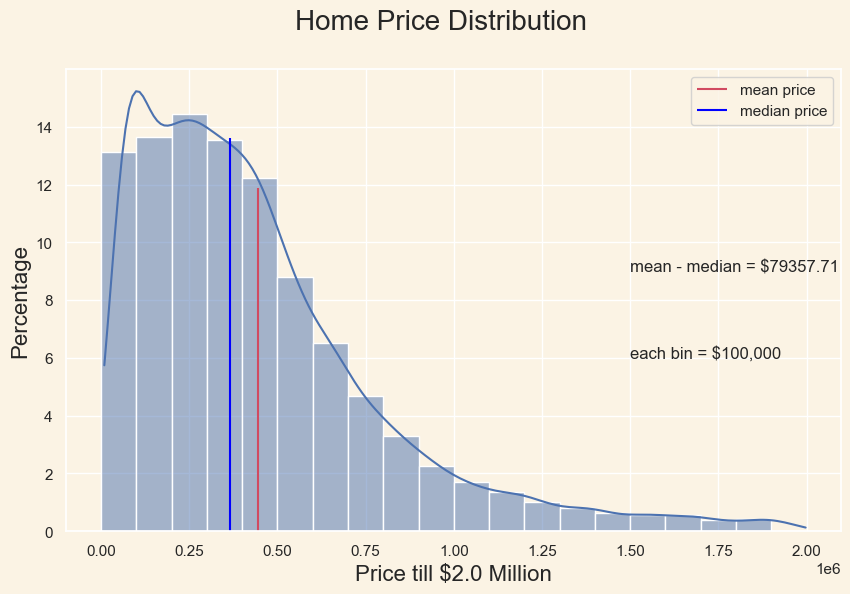

In [4]:
# display a distribution of the prices in the data set
price_distribution_graph()

Even after removing some outliers, the data is not normally distributed.

### 2. Do the home prices vary in three different counties?


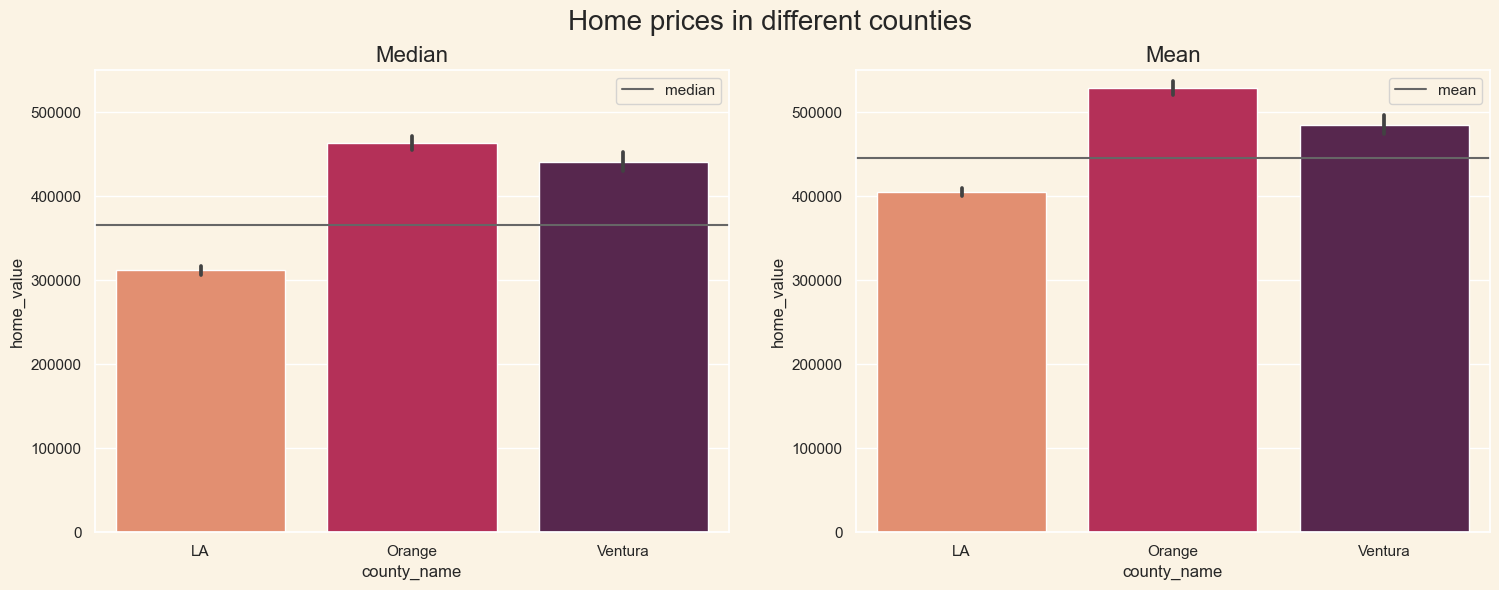

In [5]:
ex.counties_viz(train)


We see that LA counties are below the averages for median and mean. I want to confirm the price difference is significant.

$H_0$: There is no significant difference between home_value in different county_name counties.

$H_a$: There is a significant difference between home_value in different county_name counties.

In [6]:
# running stat test
ex.counties_test(train)

Variances are different. Use an non-parametric Kruskal-Wallis test.

We reject the null hypothesis.
There is a significant difference in home prices in different counties.


## 3. Is there a correlation between square footage and the home's price?

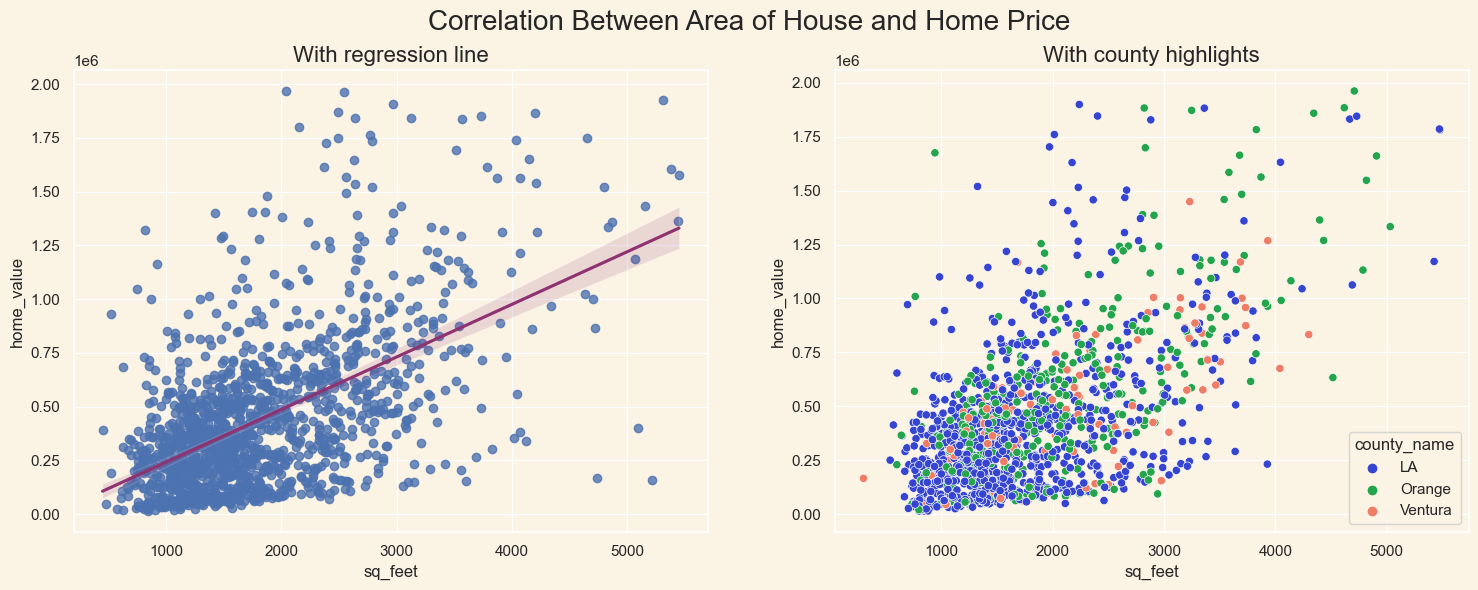

In [7]:
ex.sqft_price_viz(train)

There is a stong positive coorelation between the price of the hosue and the square footage. Lets Confirm:

$H_0$: There is no linear correlation between home_value and sq_feet

$H_a$: There is a linear correlation between home_value and sq_feet

In [8]:
# run the test
ex.sqfeet_test(train)

We reject the null hypothesis.
There is a linear correlation between home price and its size(square feet)
The correlation coefficient is 0.5
LA       correlation coefficient is  0.43

Ventura  correlation coefficient is  0.64

Orange   correlation coefficient is  0.57



## Explore Takaways

* The mean price is greater than median price by about $80K

* The most common house prices are between 200K and $300k
* There is a significant difference in the house prices among counties. Houses in Orange county have the highest prices, while prices in Los Angeles are below the median.
* There is a positive correlation between square footage and price.
* Ventura county have the strogest sq.footage / price relations.

Based on my results, I cannot discover many strong with the price in LA county. I will expect price predictions for LA county to pull all of my preditcion results down. 

## Modeling

## How I create models

I use six different regressors:

* Single and Multiple Linear Regressions with default hyperparameters
* Generalized Linear Model (TweedieRegressor) with alpha=0.5 and power=2
* Lasso Lars algorithm with alpha=0.1
* Gradient Boosting Regressor with default hyperparameters
* Decision Tree Regressor with max_depth=4
* Random Forest Regressor with max_depth=4

I have created manualy five different feature combinations, added 2 combinations with SelectKBest algorithm and added all columns in the last feature combination. In different iterations I used StandardScaler, QuantileTransformer, PolynomialFeatures and I've made one iteration with RFE (recursive feature elimination). All tools used from thesklearn library. Overall my code generated 128 different models.

#### Root mean squared error
To evaluate the performance of the regression models I'm going to use the RMSE score.

Our data contains outliers. The difference betweence between the mean and median values is around $80K. That's why I decided to use the median value as my baseline model.

In [9]:
# run all models
# the results are stored in the md.scores data frame.
# this function also writes an *.csv file with the scores
md.run_all_models()

In [10]:
# top 5 models
best_model = md.select_best_model(md.scores)

,model_name,features,scaling,RMSE_train,R2_train,RMSE_validate,R2_validate,RMSE_difference
104,Gradient Boosting Regression,poly1,standard,169112,0.670,202127,0.580,33015
92,Gradient Boosting Regression,f8,quantile,169469,0.670,202933,0.580,33464
44,Gradient Boosting Regression,f8,standard,169469,0.670,203041,0.580,33572
116,Gradient Boosting Regression,poly3,standard,166907,0.680,203109,0.580,36202
98,Gradient Boosting Regression,rfe,standard,169033,0.670,204201,0.570,35168


In [11]:
best_model

,model_name,features,scaling,RMSE_train,R2_train,RMSE_validate,R2_validate,RMSE_difference
104,Gradient Boosting Regression,poly1,standard,169112,0.670,202127,0.580,33015


Our Best model is Gradient Boosting Regression

In [13]:
# show the model performance scores
md.run_best_model()

['bedrooms', 'bathrooms', 'sq_feet', 'lot_sqft', 'house_age', 'pools']


,Gradient Bosting Regression,Scores
0,Features,"['bedrooms', 'bathrooms', 'sq_feet', 'lot_sqft..."
1,RMSE baseline,292815
2,RMSE Train Set,169469
3,RMSE Validation Set,203062
4,RMSE Test Set,195952
5,R2 Train Set,0.670
6,R2 Validation Set,0.580
7,R2 Test,0.540
8,Beats a basline by:,33.1%


Our winning model beat our baseline by 33.1%.

## Modeling summary

Observation of prediction results led me to the following conclusions:

* Gradient Boosting Regressor performed the best with our data set
* Gradient Boosting Regressor is a good model in terms of prediction but doesn't return stable results. The RMSE scores vary a lot in all 3 sets.
* Scaling type didn't affect the regression model's performance.



# Conclusions

* Overall my regression model performs good. Its predictions beat the baseline model by 33.1%
* For more stable results I would pick Random Forest Regressor or Lasso Lars Regressor.

# Next Steps

* To imporove prediction results I would recommend to pull more features from the database and look for the ones that have a strong correlation with the price in LA county.

* Also I would focus on making a model that is more stable than the current.